# Digital Musicology (DH-401)
## Assignment 1: Discovering meter
Group 6
- Mickael Achkar
- Yichen Wang
- Yinghui Jiang

Rough outline
## 1. From musical score to metrical weights
## 2. From metrical weights to periodicities
## 3. From periodicities to time signature
## 4. Accuracy of classification

In [146]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt

In [147]:
meter_dataset = pd.read_csv('DM2022 - Assignment 1 [Dataset].csv', index_col = 0, converters = {'global_onset':fractions.Fraction, 'duration': fractions.Fraction})
df = meter_dataset[['piece','timesig','global_onset', 'staff', 'voice', 'duration', 'nominal_duration', 'tied', 'gracenote']]

# ignore gracenotes for now
df = df[df['gracenote'].isna()]

# get minimum duration in noteset
min_note_length = float(df['duration'].min())
print(fractions.Fraction(min_note_length))

# we get 1/128. This minimum duration will be our sampling time.

1/128


,piece,timesig,global_onset,staff,voice,duration,nominal_duration,tied,gracenote
269850,K309-1,4/4,0,1,1,1/2,1/2,NaN,NaN
269852,K309-1,4/4,2,1,1,1/2,1/2,NaN,NaN
269854,K309-1,4/4,4,1,1,3/8,1/4,NaN,NaN
269856,K309-1,4/4,11/2,1,1,1/16,1/16,NaN,NaN
269858,K309-1,4/4,23/4,1,1,1/16,1/16,NaN,NaN
...,...,...,...,...,...,...,...,...,...
272217,K309-1,4/4,617,1,1,1/4,1/4,NaN,NaN
272218,K309-1,4/4,617,1,1,1/4,1/4,NaN,NaN
272221,K309-1,4/4,618,1,1,1/4,1/4,NaN,NaN
272222,K309-1,4/4,618,1,1,1/4,1/4,NaN,NaN


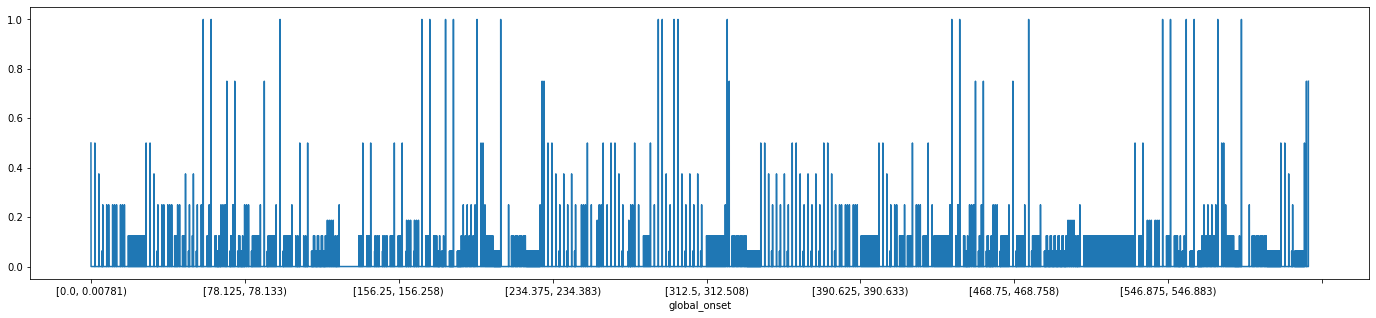

In [148]:
# For one piece and staff
one_piece = df[(df['piece'] == 'K309-1') & (df['staff'] == 1)]

#Partition the global_onsets in bins
bins = np.arange(0, (one_piece['global_onset'].max()+min_note_length+1e-10), min_note_length)
binned_onsets = pd.cut(one_piece['global_onset'], bins, right = False)

#Compute the sum of duration of all overlapping events with onsets in each bin
binned_durations = one_piece.groupby(binned_onsets)['duration'].sum().apply(float)
binned_durations.plot(figsize=(24,5));

one_piece

# ignore grace notes or consider them as normal notes by using nominal_duration (check impact to classification)
# we need to sum up ties based on piece and staff and voice
# we sample at 1/128, then sum up note duration by piece and staff at each global_onset

In [149]:
# For all pieces and staves
total_durations_df = df.groupby(['piece','staff'])['global_onset'].max()
total_durations = total_durations_df.to_dict()

for key,value in total_durations.items():
    total_durations[key] = float(value)

df = df[['piece','staff','global_onset','duration']]
# df = df.astype({'global_onset':'float', 'duration':'float'})

time_ranges = {}
for key,value in total_durations.items():
    time_ranges[key] = np.arange(0, value, min_note_length)